In [80]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st


In [81]:
path_to_bhrcfile = '/Users/zeleninam2/Documents/projects/cbcl_ksads_work/revision_2023/data/BHRC/Pine_129BHRC_2022_04_14.csv'
path_to_demofile = '/Users/zeleninam2/Documents/projects/cbcl_ksads_work/revision_2023/data/BHRC/Zugman_BHRC_2022_02_17.csv'

In [84]:
def load_bhrc(path_to_mydata, hypothesis, do_print = False): 
    # hypothesis in 1, 2a, 2b
    # measure in 'cbclaff', 'anxiousdep', 'withdrawndep'
    bhrcfile = pd.read_csv(path_to_mydata)
    exactly_13=bhrcfile.query("age >= 13.0 & age <= 13.01")
    '''
    --> 5. Enjoys little (dom_s08_cbclp_w0w2 - cl5 - Few things give pleasure)
    --> 14. Cries (dom_s08_cbclp_w0w2 - cl14 - Cries a lot)
    --> 18. Harms self (cl18 - Hurts him/herself on purpose or tried to kill him/herself)
    --> 24. Doesn’t eat well (cl24 - Is hard to eat)
    --> 35. Worthless (cl35 - Feels worthless or inferior)
    --> 52. Guilty (cl52 - Feels very guilty)
    --> 54. Tired (cl54 - Feels too tired for no reason)
    --> 60. Apathetic - leave it because it's not in CBCL
    --> 76. Sleeps less (cl76 - Sleep less than most children)
    --> 77. Sleeps more (cl77 - Sleep more than most children during the day and / or at night)
    --> 91. Talks/thinks suicide (cl91 - Say you're going to kill yourself)
    --> 100. Sleep problems (cl100 - Have sleep problems)
    --> 102. Lacks energy (cl102 - Is poorly active, slow in movement, or lacking energy)
    --> 103. Sad (cl103 - Is unhappy, sad or depressed)
    '''
    relevant_depression_columns = ["cl5", "cl14", "cl18", "cl24", "cl35", "cl52", "cl54", "cl76", "cl77", "cl91", "cl100", "cl102", "cl103"]
    # handling missing data
    if do_print:
        # Check if there are no "99"s
        for column in relevant_depression_columns:
            print(bhrcfile[column].value_counts())
        checkdf = bhrcfile[(bhrcfile[relevant_depression_columns] == 99).any(axis=1)]
        print(checkdf.redcap_event_name.value_counts())
        checkdf['age_9to13'] = (checkdf.p1dawbaage.astype(float) >= 9.0) & (checkdf.p1dawbaage.astype(float) <= 13.0)
        print(checkdf.age_9to13.value_counts())
    bhrcfile['age_9to13'] = (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
    bhrcfile = bhrcfile[~(bhrcfile[relevant_depression_columns] == 99).any(axis=1)]
    # relevant_depression_columns = ["cl5", "cl14", "cl18", "cl24", "cl35", "cl52", "cl54", "cl76", "cl77", "cl91", "cl100", "cl102", "cl103"]
    bhrcfile['cbcl_dsm_depression'] = bhrcfile.cl5 + bhrcfile.cl14 + bhrcfile.cl18 + bhrcfile.cl24 + bhrcfile.cl35 + bhrcfile.cl52 + bhrcfile.cl54 + bhrcfile.cl76 + bhrcfile.cl77 + bhrcfile.cl91 + bhrcfile.cl100 + bhrcfile.cl102 + bhrcfile.cl103
    if do_print:
        print(bhrcfile['cbcl_dsm_depression'].value_counts())
        # checking for NaNs
        print('HEALTHY')
        print(bhrcfile.dcany.value_counts())
        
        print('\nDEPRESSION')
        print(bhrcfile.dcmadep.value_counts())
        print(bhrcfile.dcotdep.value_counts())
        
        print('\nANXIETY')
        print(bhrcfile.dcsepa.value_counts())
        print(bhrcfile.dcspph.value_counts())
        print(bhrcfile.dcsoph.value_counts())
        print(bhrcfile.dcpanic.value_counts())
        print(bhrcfile.dcagor.value_counts())
        print(bhrcfile.dcgena.value_counts())
        print(bhrcfile.dcotanx.value_counts())
        
        print('\nADHD')
        print(bhrcfile.dcanyhk.value_counts())
    bhrcfile['depression_clinician'] = (bhrcfile.dcmadep == 2) | (bhrcfile.dcotdep == 2)
    bhrcfile['healthy_clinician'] = (bhrcfile.dcany == 0)
    bhrcfile['anxiety_clinician'] = (bhrcfile.dcsepa == 2) | \
                            (bhrcfile.dcspph == 2) | \
                            (bhrcfile.dcsoph == 2) | \
                            (bhrcfile.dcpanic == 2) |\
                            (bhrcfile.dcagor == 2) | \
                            (bhrcfile.dcgena == 2) | \
                            (bhrcfile.dcotanx == 2) 
    bhrcfile['ADHD_clinician'] = (bhrcfile.dcanyhk == 2)
    bhrcfile['depYES_anxietyadhdNO_clinician'] = (bhrcfile.depression_clinician == True) & ((bhrcfile.anxiety_clinician == False) & (bhrcfile.ADHD_clinician == False))
    bhrcfile['depNO_anxietyadhdYES_clinician'] = (bhrcfile.depression_clinician == False) & ((bhrcfile.anxiety_clinician == True) | (bhrcfile.ADHD_clinician == True))
    
    bhrcfile['depression_clinician_9to13'] = (bhrcfile.depression_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
    #bhrcfile['healthy_clinician_9to13'] = (bhrcfile.healthy_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
    bhrcfile['healthy_clinician_9to13'] = (bhrcfile.depression_clinician == False) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)    
    bhrcfile['depYES_anxietyadhdNO_clinician_9to13'] = (bhrcfile.depYES_anxietyadhdNO_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
    bhrcfile['depNO_anxietyadhdYES_clinician_9to13'] = (bhrcfile.depNO_anxietyadhdYES_clinician == True) & (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
    bhrcfile['all_9to13'] = (bhrcfile.p1dawbaage.astype(float) >= 9.0) & (bhrcfile.p1dawbaage.astype(float) <= 13.0)
    #removing all rows where p1dawbaage <9 or >13
    bhrcfile = bhrcfile[bhrcfile.p1dawbaage >= 9]
    bhrcfile = bhrcfile[bhrcfile.p1dawbaage <= 13]
    if do_print:
        print(bhrcfile.shape)
        print(bhrcfile['p1dawbaage'].value_counts()) 
    bhrcfile = bhrcfile.replace('wave0_arm_1', 0)
    bhrcfile = bhrcfile.replace('wave1_arm_1', 1)
    bhrcfile = bhrcfile.replace('wave2_arm_1', 2)    
    bhrcfile = bhrcfile.sort_values(['ident', 'p1dawbaage'])
    bhrcfile = bhrcfile.groupby(by=['ident'])
    bhrcfile = bhrcfile.first('1D')
    bhrcfile = bhrcfile.reset_index(level=0)
    # checking numbers of depressed etc
    print("\nDepressed 9 to 13 - clinician")
    print(bhrcfile['depression_clinician_9to13'].value_counts())
    print("\nHealthy 9 to 13 - clinician")
    print(bhrcfile['healthy_clinician_9to13'].value_counts())
    print("\ndepYES_anxietyadhdNO_clinician - clinician")
    print(bhrcfile['depYES_anxietyadhdNO_clinician_9to13'].value_counts())
    print("\ndepNO_anxietyadhdYES_clinician - clinician")
    print(bhrcfile['depNO_anxietyadhdYES_clinician_9to13'].value_counts())
    print("\nall 9 to 13")
    print(bhrcfile['all_9to13'].value_counts())
    mybhrcfile = bhrcfile[['ident', 'p1dawbaage', 'cl_anxdep', 'cl_withdep', 'redcap_event_name', 'depression_clinician_9to13', 'healthy_clinician_9to13', 'depYES_anxietyadhdNO_clinician_9to13', 'depNO_anxietyadhdYES_clinician_9to13', 'cbcl_dsm_depression']]
    mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)
    # check if lists for h1 and h2a are identical for some reason
    print('\nEQUALS??')
    print(mybhrcfile['healthy_clinician_9to13'].equals(mybhrcfile['depNO_anxietyadhdYES_clinician_9to13']))
    if hypothesis == '1':
        is_gs_pos =  mybhrcfile['gs_depression']==1
        is_gs_neg =  mybhrcfile['healthy_clinician_9to13']==True
    elif hypothesis == '2a':
        is_gs_pos =  mybhrcfile['gs_depression']==1
        is_gs_neg =  mybhrcfile['depNO_anxietyadhdYES_clinician_9to13']==True
    elif hypothesis == '2b':
        is_gs_pos =  mybhrcfile['depYES_anxietyadhdNO_clinician_9to13']==1
        is_gs_neg =  mybhrcfile['depNO_anxietyadhdYES_clinician_9to13']==True
    pos_gs_all = mybhrcfile[is_gs_pos]
    neg_gs_all = mybhrcfile[is_gs_neg]
    num_pos = pos_gs_all.shape[0]
    num_neg = neg_gs_all.shape[0]
    print('\nHypothesis = %s' % hypothesis)
    print('All positives in sample = %d' % num_pos)
    print('All negatives in sample = %d' % num_neg)
    if hypothesis == '1':
        size_subsample = num_pos*10-num_pos # !
        neg_gs_subsample = neg_gs_all.sample(n = size_subsample)
    elif hypothesis == '2a' or hypothesis == '2b':
        size_subsample = num_neg
        neg_gs_subsample = neg_gs_all.sample(n = size_subsample)
    # mix, then shuffle
    frames = [pos_gs_all, neg_gs_subsample]
    my_subsample = pd.concat(frames)
    my_subsample = my_subsample.sample(frac = 1)
    return my_subsample

def split_sex (datafile, path_to_demo, sex='boys'):
    demodata = pd.read_csv(path_to_demo)
    data_all = pd.merge(datafile, demodata, how='left', left_index = True, right_index = True, indicator=True)
    # I checked and indicator is always "both"
    '''if len(data_all.query('_merge != "both"')) != 0:
        print('merge indicator:')
        print(data_all._merge.value_counts())
        print(data_all.loc[data_all._merge == 'left_only'])
        '''
    data_boys = data_all[data_all['gender'] == 1]
    data_girls = data_all[data_all['gender'] == 2]
    if sex == 'boys':
        to_return = data_boys
    elif sex == 'girls':
        to_return = data_girls
    print('Length of dataset - sex n = %s, sample size n = %d' % (sex, to_return.shape[0]))
    return to_return   

# -----------------
# ANALYSIS FUNCTONS
# -----------------

# help function for bootstrapping
def gen_auc_boots(scores, truth, nboots, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth.iloc[boot_ind]
        boot_score = scores.iloc[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

# main analysis function
def run_aucroc_and_plot(my_dat, path_to_save_plots, name_to_save, mymeasure, hypothesis, nboots=100, target_auc=0.8, do_print = False):
    # [TODO] CHANGE TARGET_AUC FOR HYP 2B
    # using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    print('BEGIN AUCROC...')
    if do_print:
        print(my_dat.head())
    if mymeasure == 'cbclaff':
        y_measure_df = my_dat['cbcl_dsm_depression']
    elif mymeasure == 'anxiousdep':
        y_measure_df = my_dat['cl_anxdep']
    elif mymeasure == 'withdrawndep':
        y_measure_df = my_dat['cl_withdep']    
            # I'm getting weird scores for H2a, 2b
    # I think the problem is here
    if hypothesis in ['1', '2a']:   
        y_true_df = my_dat['depression_clinician_9to13'] # called y_test in the example
    elif hypothesis == '2b':
        y_true_df = my_dat['depYES_anxietyadhdNO_clinician_9to13'] # called y_test in the example
    if do_print:
        print(my_dat.head())        
    sample_auc_score = roc_auc_score(y_true_df, y_measure_df)
    print('\nSingle AUCROC score without bootstrapping:')
    print(sample_auc_score)
    #print('\nSingle AUCROC score without bootstrapping = %d' % (sample_auc_score))
    # plotting
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_true_df, y_measure_df)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    # We save the data for future plotting of all hypotheses in one figure, for the paper
    with open(path_to_save_plots+name_to_save+'_true.npy', 'wb') as f:
        np.save(f, y_true_df)
    with open(path_to_save_plots+name_to_save+'_'+mymeasure+'.npy', 'wb') as f:
        np.save(f, y_measure_df)
    # bootstrapping
    boot_ind = np.random.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
    boot_truth = y_true_df.iloc[boot_ind]
    boot_score = y_measure_df.iloc[boot_ind]
    rng = np.random.default_rng()
    boots = gen_auc_boots(y_measure_df, y_true_df, nboots=1000, rng=rng)
    boots = np.hstack([boots, np.array([sample_auc_score])])
    #print('min bootstrapping aucroc = %d' % (min(boots)))
    #print('max bootstrapping aucroc = %d' % (max(boots)))  
    print('min bootstrapping aucroc:')
    print(min(boots))
    print('max bootstrapping aucroc:')
    print(max(boots))
    p_onesided = (boots >= target_auc).mean()
    print('p_onesided = %d' % (p_onesided))  
    p_twosided1 = (boots > target_auc).mean()
    p_twosided2 = (boots < target_auc).mean()
    p_twosided = min(p_twosided1, p_twosided2)*2
    print('p_twosided = %d' % (p_twosided))  
    boots_mean_AUCROC = np.mean(boots)
    q_25 = np.quantile(boots, .025)
    q_75 = np.quantile(boots, .975)
    #print('boots_mean_AUCROC = %d(%d, %d)' % (boots_mean_AUCROC, q_25, q_75)) # why is this not working?
    print('boots_mean_AUCROC =')
    print(str(boots_mean_AUCROC)+'('+str(q_25)+','+str(q_75)+')') # this is so ugly omg but at least it's working
    # for confusion matrix for optimal thresholds:
    y_true = y_true_df.tolist()
    y_measure = y_measure_df.tolist()
    print('\n...END AUCROC')
    return (y_true, y_measure)

/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8944878472222223


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


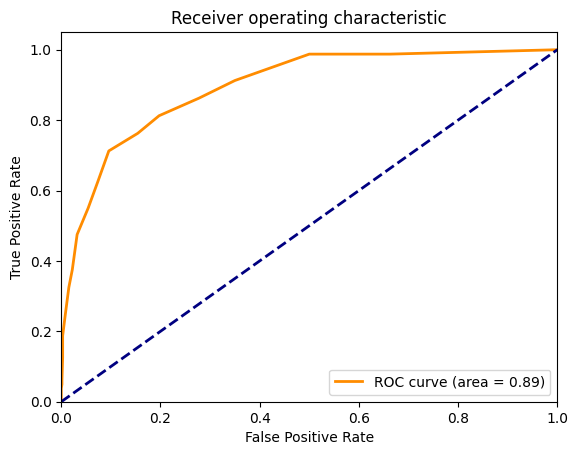

min bootstrapping aucroc:
0.8316659810777458
max bootstrapping aucroc:
0.9436322696644318
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8948954769932618(0.8572184684684685,0.9271540105957803)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 423

Measure: cbclaff
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.907466340269278


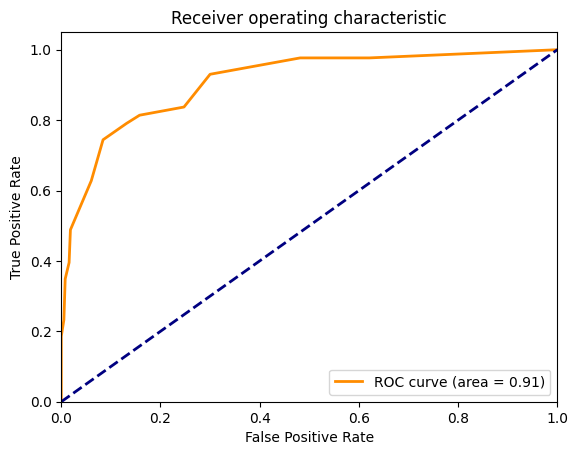

min bootstrapping aucroc:
0.81975
max bootstrapping aucroc:
0.9741899852724596
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9072634471147448(0.855953557312253,0.95246717971933)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 377

Measure: cbclaff
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8786963434022258


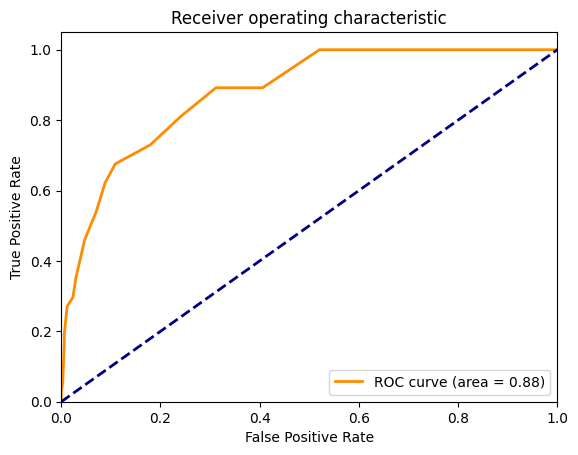

min bootstrapping aucroc:
0.7926984126984127
max bootstrapping aucroc:
0.9497157071783937
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8789544995114636(0.8272644927536232,0.9255564387917329)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8956857638888889


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


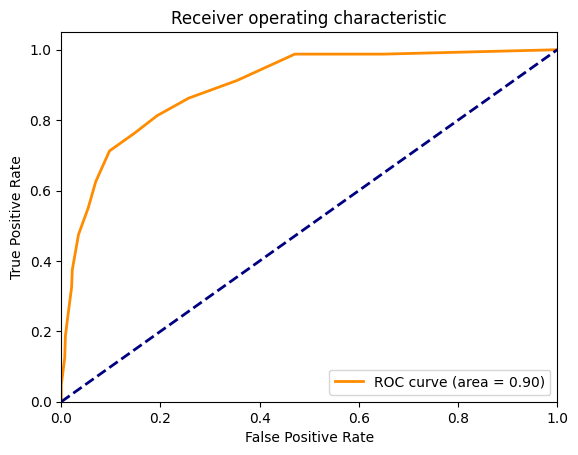

min bootstrapping aucroc:
0.8422224462704374
max bootstrapping aucroc:
0.9386293832790036
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8956247747147769(0.8594146961110025,0.9279186228482004)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 451

Measure: cbclaff
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.9008207934336525


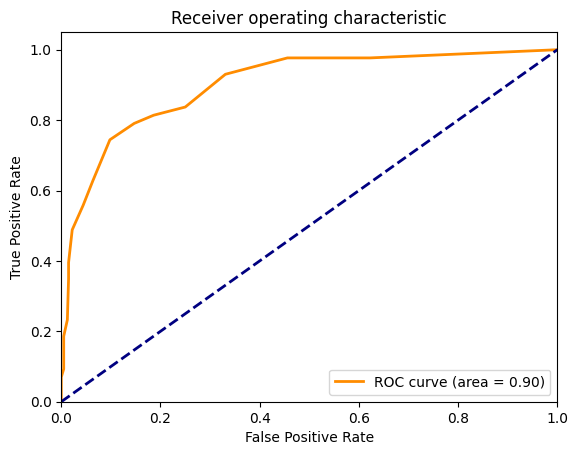

min bootstrapping aucroc:
0.8109149993628137
max bootstrapping aucroc:
0.9587067463281055
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9002118278862669(0.8438726948245092,0.9425144747725392)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 349

Measure: cbclaff
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8887300762300763


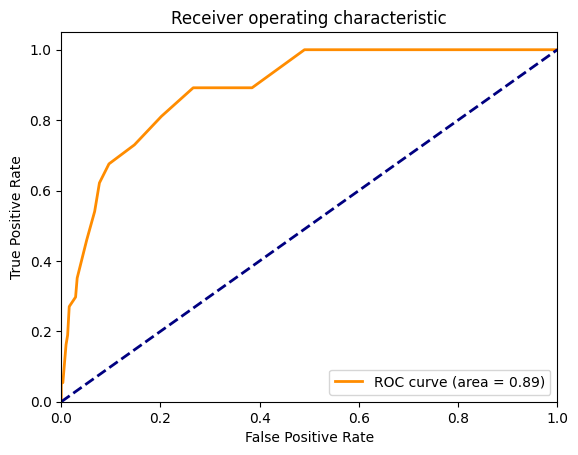

min bootstrapping aucroc:
0.7843446601941748
max bootstrapping aucroc:
0.9671875000000001
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8878627307579634(0.8376212751212752,0.9312434691745037)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.888236920524715


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


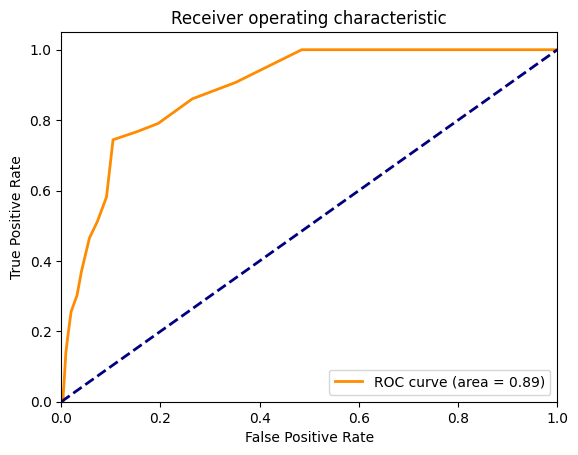

min bootstrapping aucroc:
0.8190333879623382
max bootstrapping aucroc:
0.9514160156250001
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8885319202610626(0.8454605263157895,0.9273755583405636)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 463

Measure: cbclaff
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8896165527714502


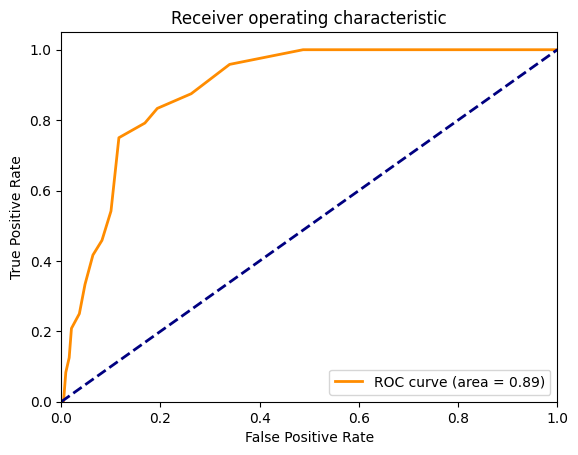

min bootstrapping aucroc:
0.809486166007905
max bootstrapping aucroc:
0.9578869047619049
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8901316843423737(0.83997969837587,0.9339734471313419)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 337

Measure: cbclaff
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8840615690168818


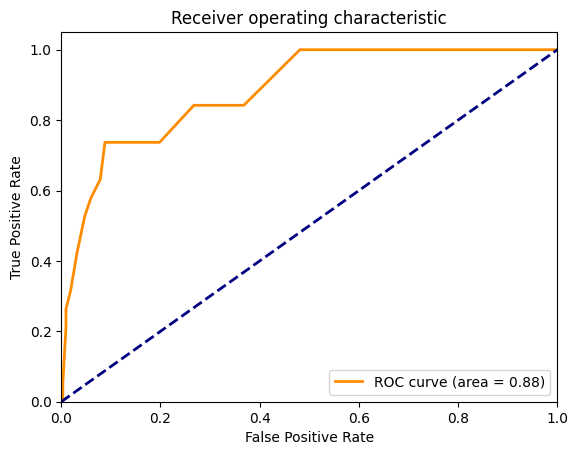

min bootstrapping aucroc:
0.760351966873706
max bootstrapping aucroc:
0.9746793454223794
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8835232338882292(0.8056632511769592,0.9485370950888192)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8997569444444444


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


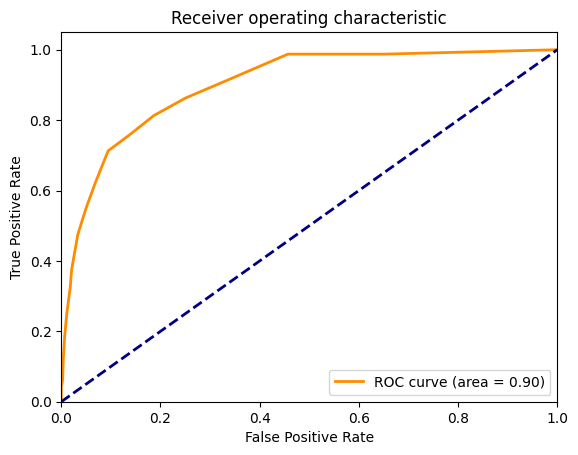

min bootstrapping aucroc:
0.8290586695607762
max bootstrapping aucroc:
0.9496814891737317
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9003658790465658(0.8653224660842389,0.9297135416666666)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 449

Measure: cbclaff
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.9027093596059113


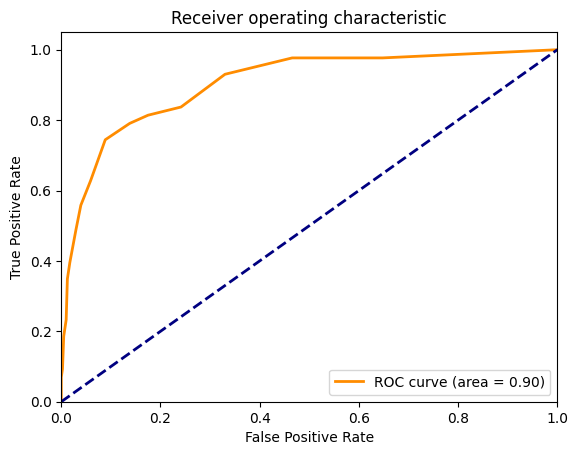

min bootstrapping aucroc:
0.8003646580583453
max bootstrapping aucroc:
0.9626673840267814
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9012804390634962(0.8463265306122449,0.9457142857142856)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 351

Measure: cbclaff
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8959373386124978


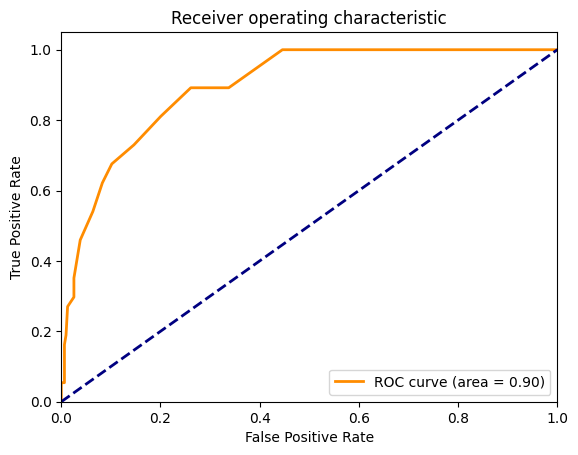

min bootstrapping aucroc:
0.8237903225806452
max bootstrapping aucroc:
0.9605012388031257
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8960734518484521(0.8515380094043887,0.9355707395498393)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8989756944444445


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


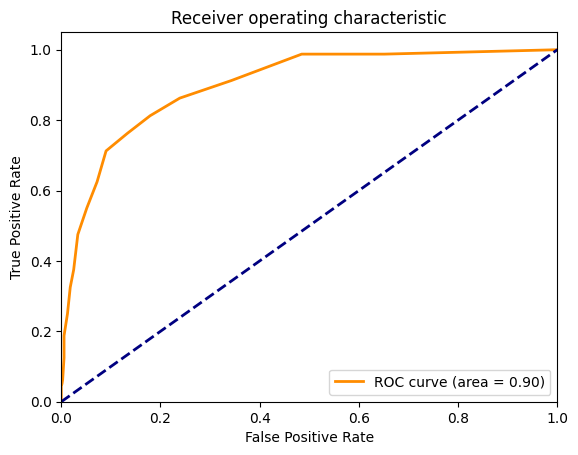

min bootstrapping aucroc:
0.8325938457609806
max bootstrapping aucroc:
0.9532448463069224
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8992103976054643(0.8641281417636069,0.9304500978473581)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 453

Measure: cbclaff
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.9003970504821327


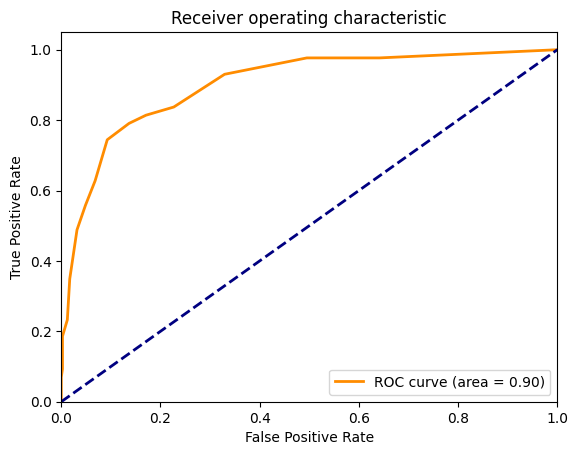

min bootstrapping aucroc:
0.7982445520581114
max bootstrapping aucroc:
0.9654403567447045
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8994807911291824(0.8371933621933623,0.9442446043165468)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 347

Measure: cbclaff
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8974280732345249


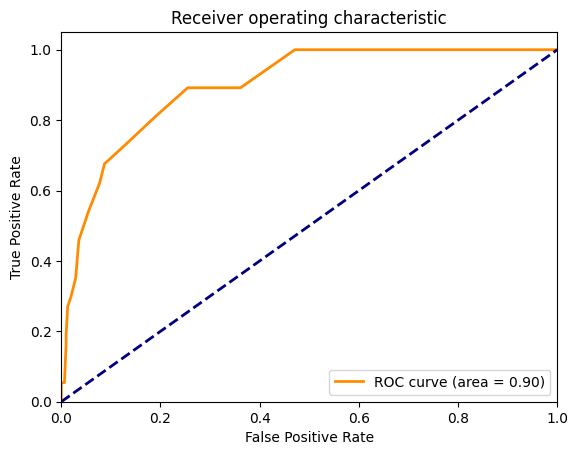

min bootstrapping aucroc:
0.8237179487179487
max bootstrapping aucroc:
0.9633432539682539
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8968847308818055(0.8482435823200155,0.9379781420765028)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.877576725753433


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


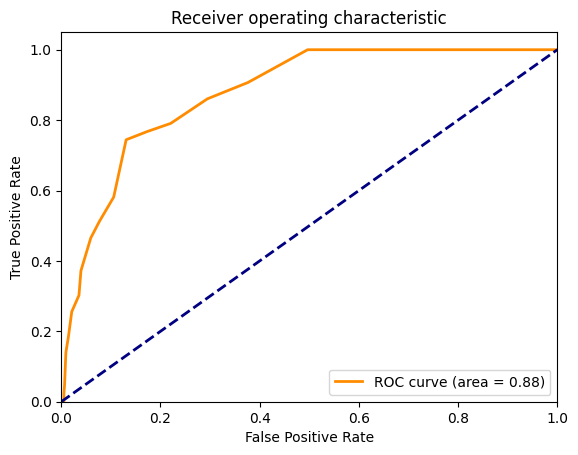

min bootstrapping aucroc:
0.7970784505208333
max bootstrapping aucroc:
0.9442703595134606
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8793934405373048(0.8382901967364402,0.9188918086519172)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 430

Measure: cbclaff
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8831075533661742


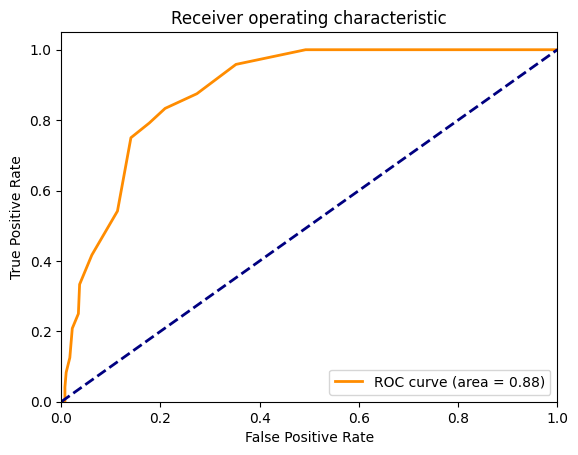

min bootstrapping aucroc:
0.7727204106280194
max bootstrapping aucroc:
0.9492682926829268
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8826790282926399(0.8309357641361629,0.9292344453634777)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 370

Measure: cbclaff
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8685710001499475


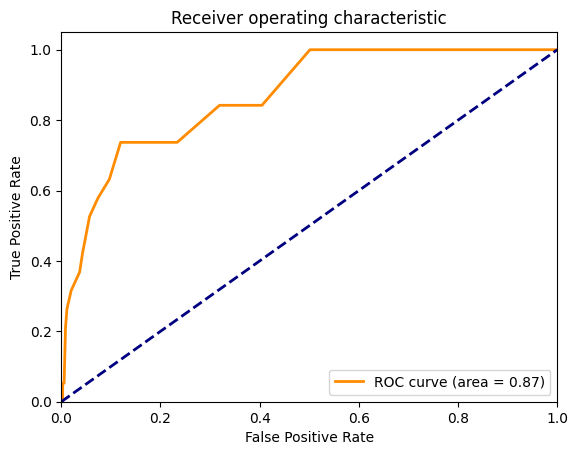

min bootstrapping aucroc:
0.6834733893557423
max bootstrapping aucroc:
0.9865727699530517
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8683445164746507(0.7863794191919192,0.936223530885854)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8960416666666667


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


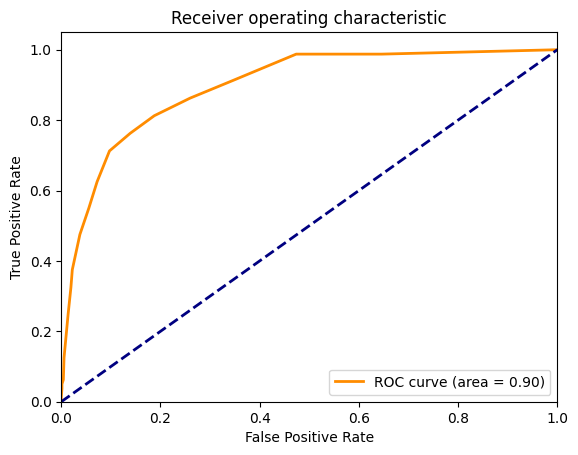

min bootstrapping aucroc:
0.8247617452162908
max bootstrapping aucroc:
0.9404922839235239
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8956049161808096(0.8568079539508111,0.9264605978260869)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 458

Measure: cbclaff
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8940319417203698


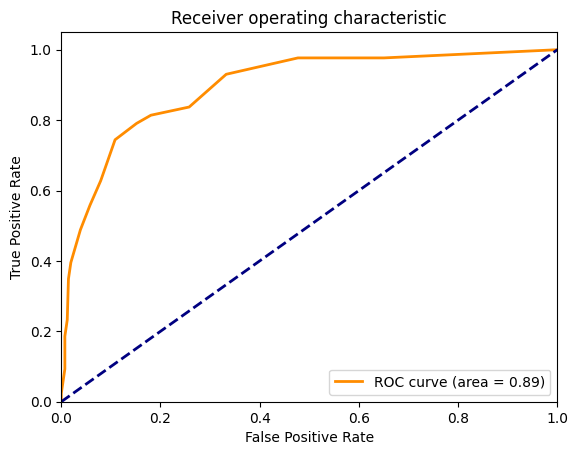

min bootstrapping aucroc:
0.8022965214454576
max bootstrapping aucroc:
0.9569222670643972
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8940491137978689(0.8411861058919883,0.9374208526804558)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 342

Measure: cbclaff
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8987151085511741


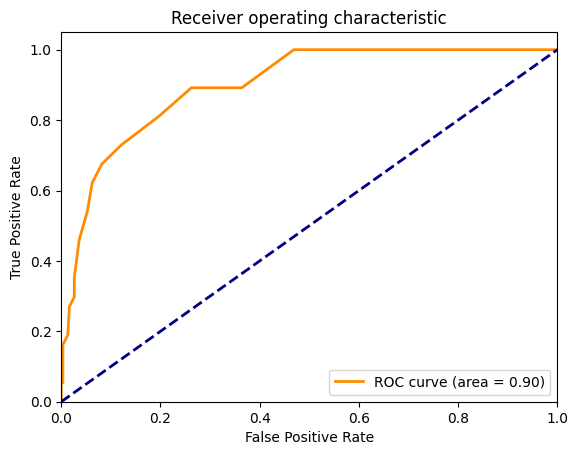

min bootstrapping aucroc:
0.8184835597967015
max bootstrapping aucroc:
0.9633584404076208
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9002271271618655(0.8510620292798511,0.9397371776012552)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.894592013888889


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


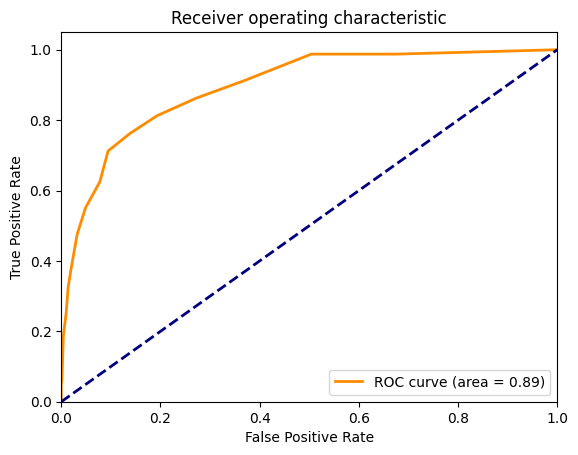

min bootstrapping aucroc:
0.8277056865276173
max bootstrapping aucroc:
0.9477802618971575
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8957983256772074(0.8591493055555555,0.9311675630434446)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 448

Measure: cbclaff
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8890324432960092


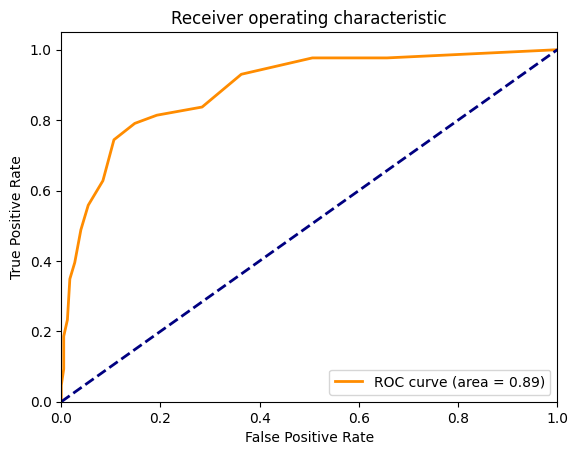

min bootstrapping aucroc:
0.7892071672559478
max bootstrapping aucroc:
0.9633649153028998
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.888400919178638(0.8326882477128781,0.9374363276802301)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 352

Measure: cbclaff
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.9016302016302016


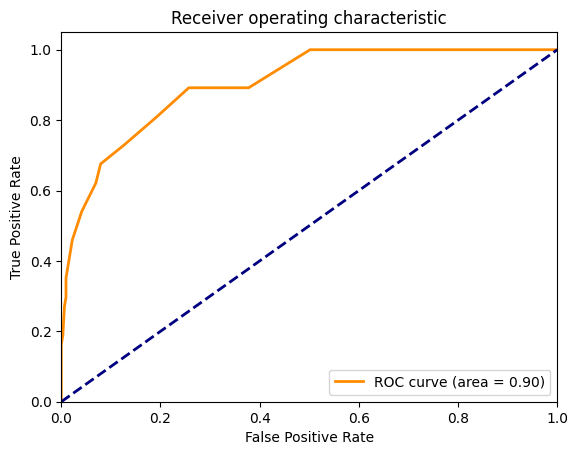

min bootstrapping aucroc:
0.8283026113671275
max bootstrapping aucroc:
0.965992210506317
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.9026343014423013(0.8523795953263038,0.945283556568823)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: cbclaff
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8829375441614697


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


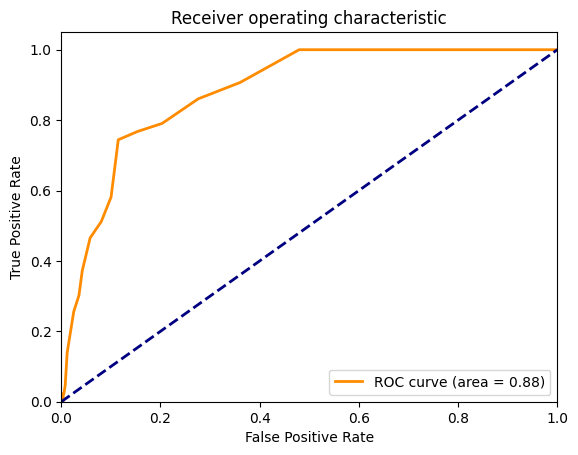

min bootstrapping aucroc:
0.8045247395833333
max bootstrapping aucroc:
0.9467045856229312
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8832468429030557(0.8408965326702584,0.9199019977384093)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 443

Measure: cbclaff
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8870326173428799


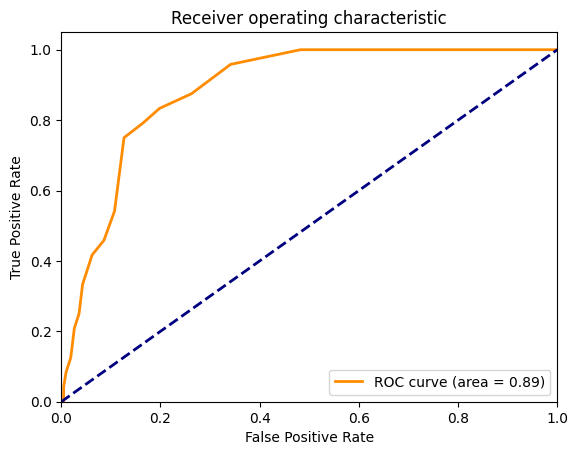

min bootstrapping aucroc:
0.8006657639359062
max bootstrapping aucroc:
0.9621400198609732
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8867519454422991(0.8360591900311526,0.9307659208261618)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 357

Measure: cbclaff
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8751167860479602


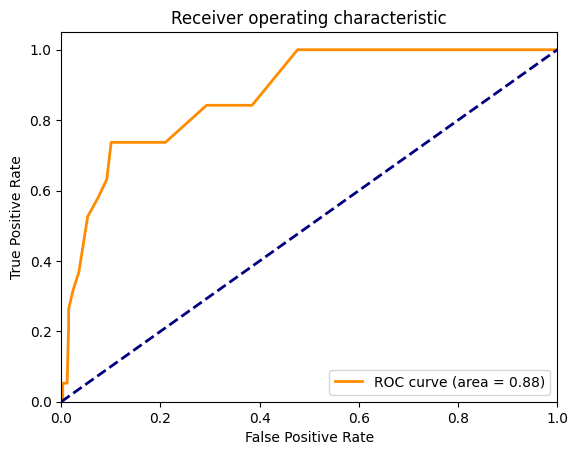

min bootstrapping aucroc:
0.7427536231884058
max bootstrapping aucroc:
0.98670465337132
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8763144032442217(0.7997032640949555,0.9432098765432099)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8637152777777779


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


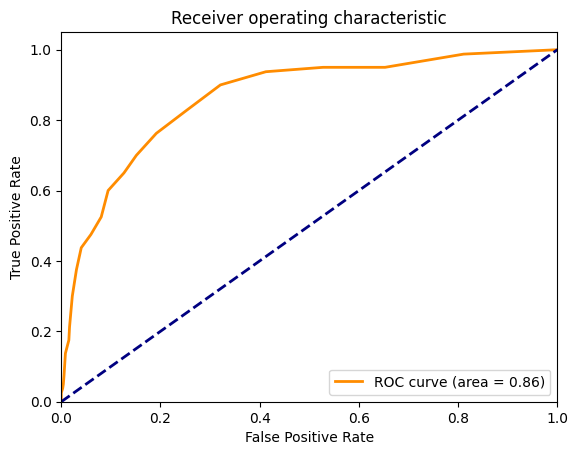

min bootstrapping aucroc:
0.772322944972826
max bootstrapping aucroc:
0.927890625
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8633539996165777(0.8168858301585351,0.9037440557618396)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 452

Measure: anxiousdep
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8556035708193552


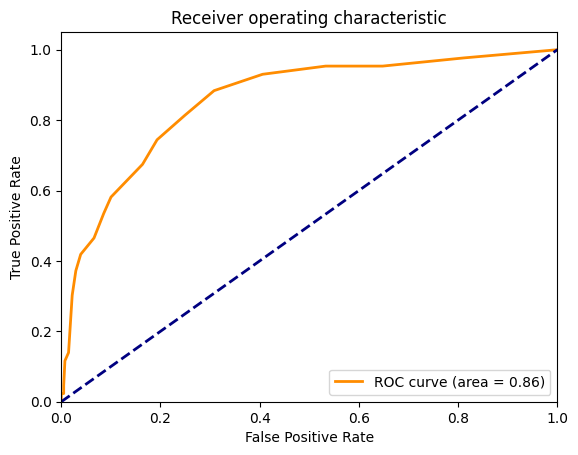

min bootstrapping aucroc:
0.7543145555193749
max bootstrapping aucroc:
0.9428358208955224
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8543096100016357(0.7903085614950022,0.9094292139644464)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 348

Measure: anxiousdep
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8733814200052142


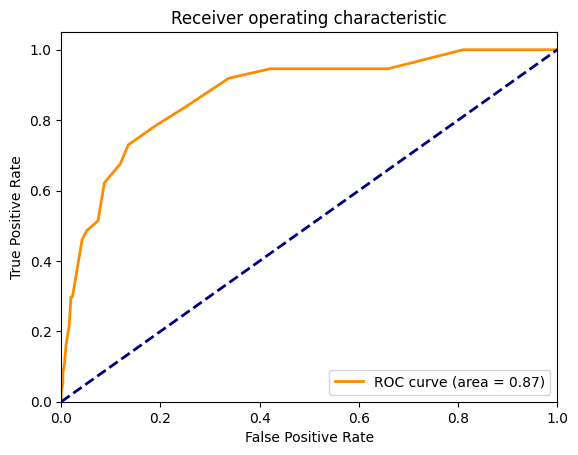

min bootstrapping aucroc:
0.7596599002849003
max bootstrapping aucroc:
0.9541026601723492
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8730278665679146(0.8074149996465683,0.9291486291486292)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8665625000000001


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


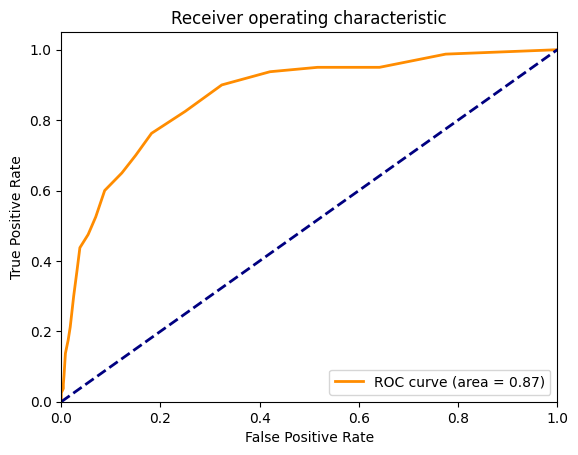

min bootstrapping aucroc:
0.7893666717077515
max bootstrapping aucroc:
0.9309898741716923
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8659369781841245(0.8241120218579235,0.9052589926701965)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 448

Measure: anxiousdep
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.860063163939133


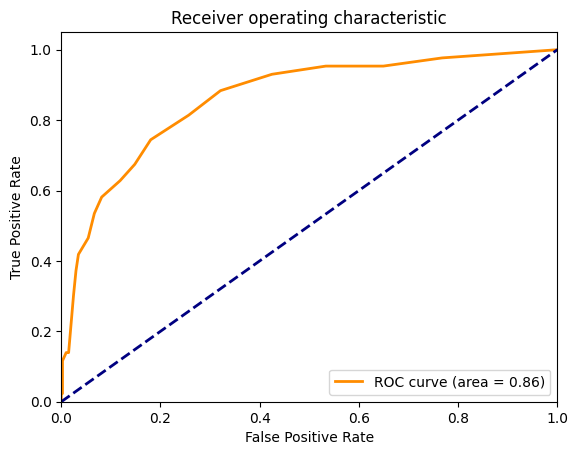

min bootstrapping aucroc:
0.7588883888388839
max bootstrapping aucroc:
0.9362464654435457
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8615959363526932(0.7976130653266332,0.9167315874632948)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 352

Measure: anxiousdep
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8731016731016731


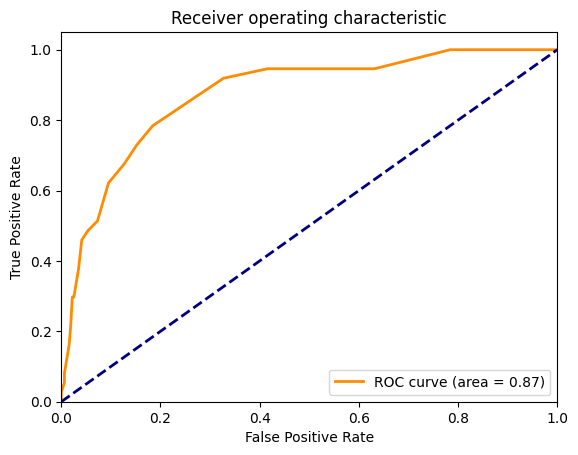

min bootstrapping aucroc:
0.7347805568664464
max bootstrapping aucroc:
0.946710903579913
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8733161792960428(0.8127635327635327,0.9274898602974313)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8248440908113421


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


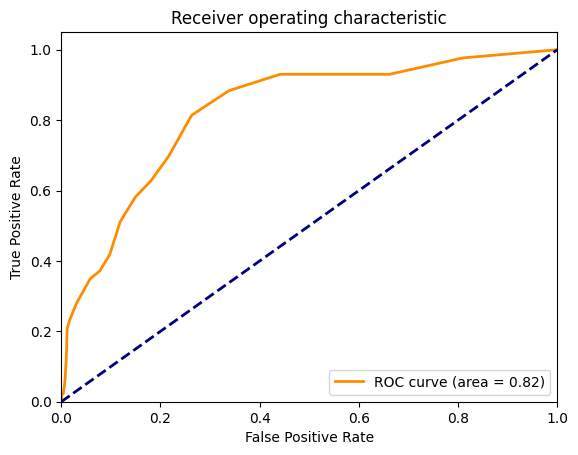

min bootstrapping aucroc:
0.6906266666666667
max bootstrapping aucroc:
0.9240953947368421
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8254924950168703(0.7578402039007092,0.882796052631579)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 437

Measure: anxiousdep
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8407990314769975


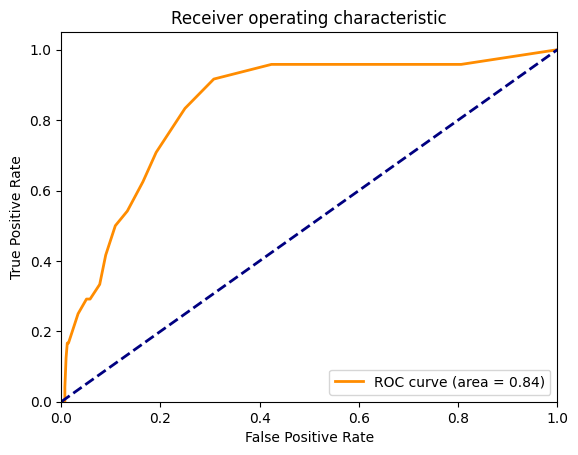

min bootstrapping aucroc:
0.6960679611650485
max bootstrapping aucroc:
0.9384157509157509
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8412693453554891(0.7597799511002445,0.9106570512820513)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 363

Measure: anxiousdep
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8079100367197063


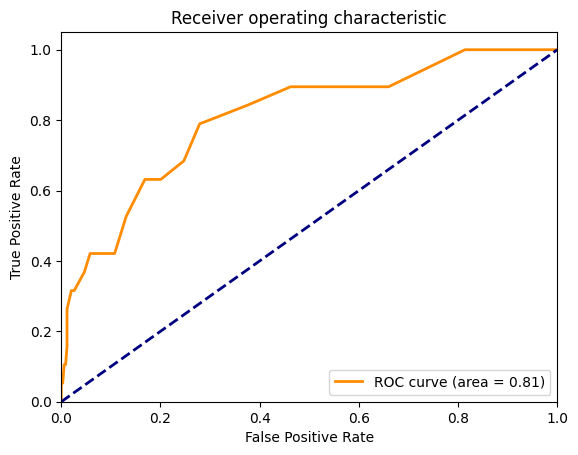

min bootstrapping aucroc:
0.5564835164835165
max bootstrapping aucroc:
0.9411078717201167
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.807804891940939(0.6906130268199233,0.9003962536023055)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8577604166666666


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


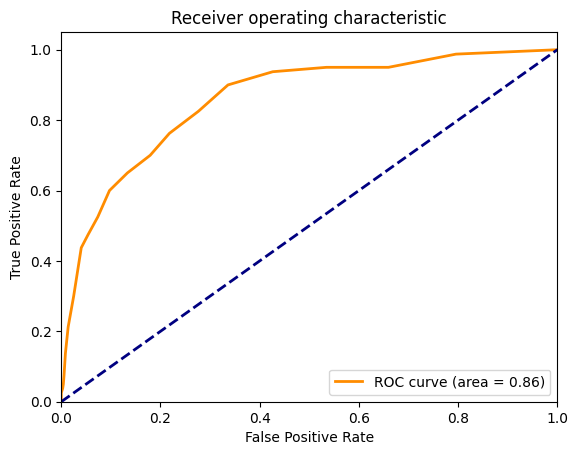

min bootstrapping aucroc:
0.7828891377379619
max bootstrapping aucroc:
0.9320444261620732
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8584228066622671(0.8145379310344828,0.8990314861223644)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 450

Measure: anxiousdep
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8537226444203189


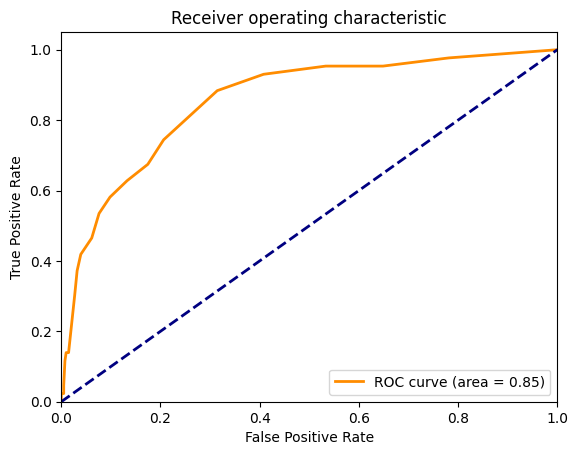

min bootstrapping aucroc:
0.6882345426673481
max bootstrapping aucroc:
0.9331153184165231
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8540339260120088(0.7892837974834515,0.9072605721393034)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 350

Measure: anxiousdep
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8619721958380107


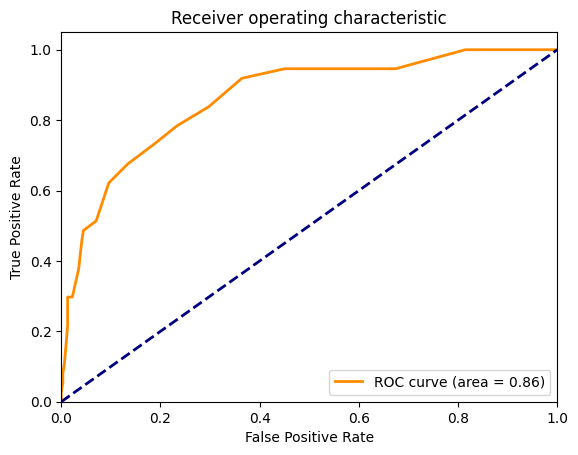

min bootstrapping aucroc:
0.7546938775510205
max bootstrapping aucroc:
0.945584961662132
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8628655893646969(0.7963478407557355,0.9192338709677419)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8676041666666667


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


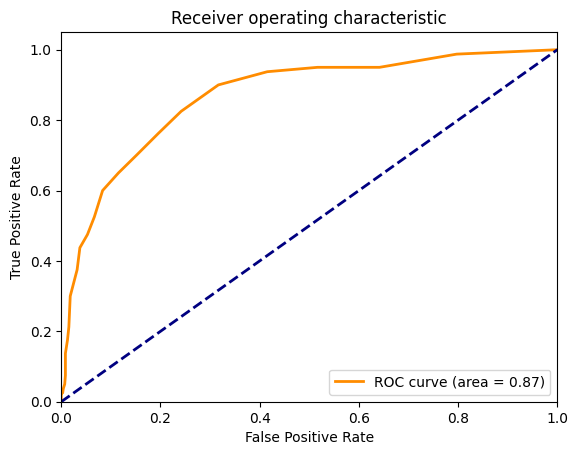

min bootstrapping aucroc:
0.7972816321799108
max bootstrapping aucroc:
0.9242612990646035
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8678263788540923(0.8242543008422678,0.9053481857859422)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 425

Measure: anxiousdep
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.860647753561427


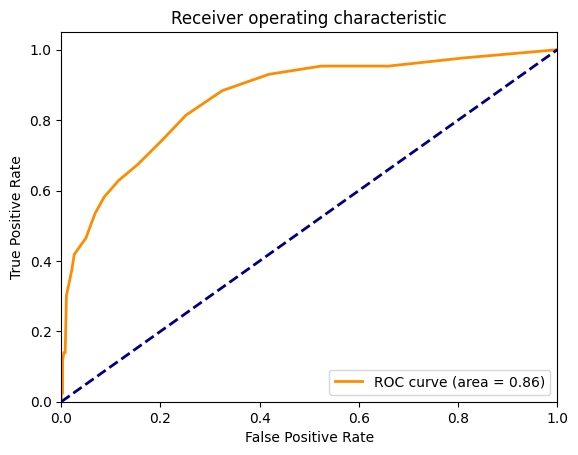

min bootstrapping aucroc:
0.762266608771168
max bootstrapping aucroc:
0.9462933439617378
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8597751016467104(0.7978376172990616,0.9171729957805907)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 375

Measure: anxiousdep
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8758196065888373


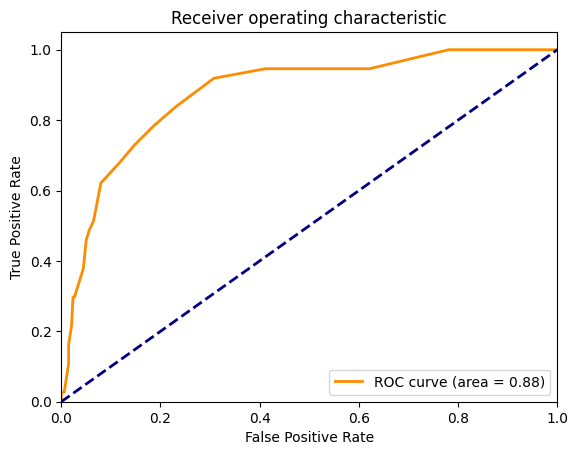

min bootstrapping aucroc:
0.7774052788420603
max bootstrapping aucroc:
0.9549016034985423
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8756942274133144(0.8111421168028703,0.9301518913392727)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8164265306749409


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


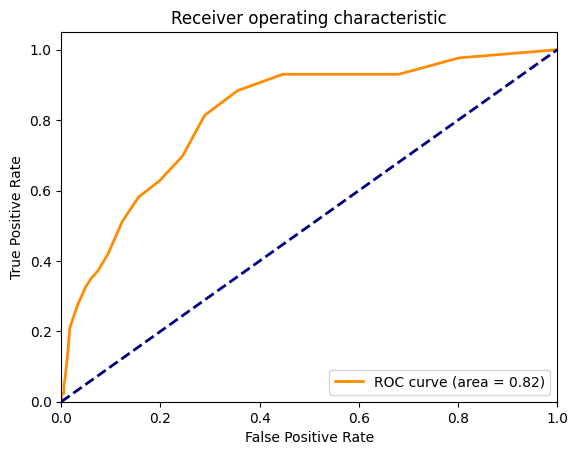

min bootstrapping aucroc:
0.6688101406365654
max bootstrapping aucroc:
0.9252654159394996
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8165551532326115(0.7439563475618179,0.8753173302484012)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 426

Measure: anxiousdep
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8191334991708126


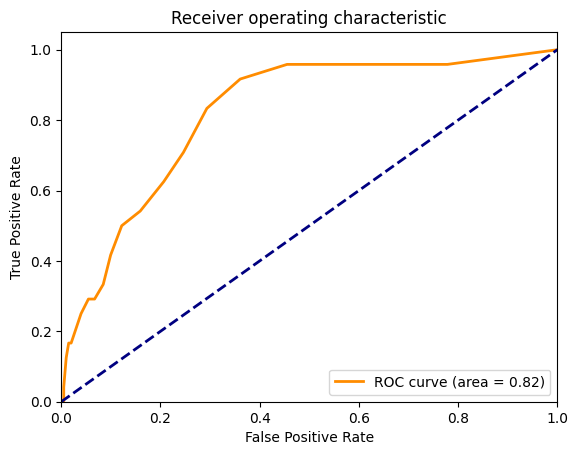

min bootstrapping aucroc:
0.6712895377128955
max bootstrapping aucroc:
0.9248439667128987
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8200026258590577(0.7314039408866996,0.8890773067331671)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 374

Measure: anxiousdep
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8100074128984434


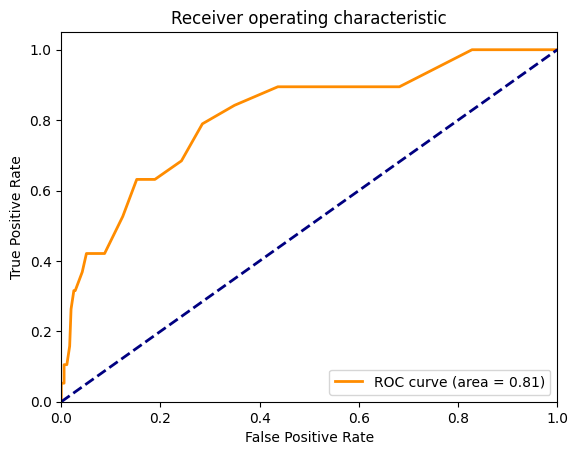

min bootstrapping aucroc:
0.54779299847793
max bootstrapping aucroc:
0.9504943502824859
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8122359572589514(0.6987929433611885,0.9037319214876033)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8603732638888889


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


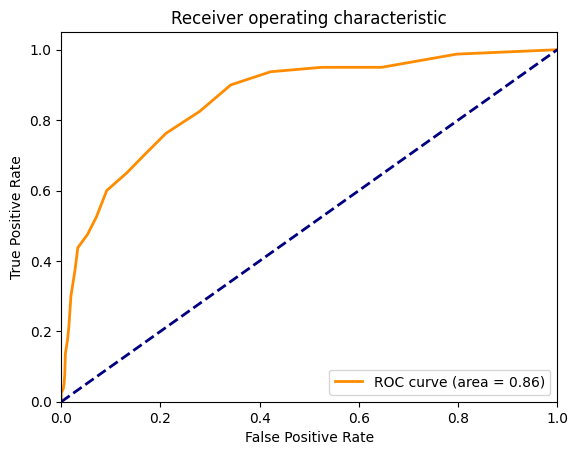

min bootstrapping aucroc:
0.7940071520411444
max bootstrapping aucroc:
0.9312152777777778
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8605060704278983(0.8155018748469031,0.9031438956450846)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 440

Measure: anxiousdep
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8558666744771833


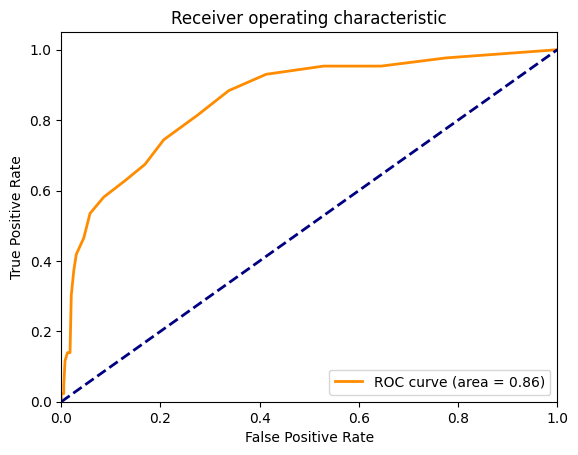

min bootstrapping aucroc:
0.7300625
max bootstrapping aucroc:
0.9387798765205697
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8571634910690299(0.7946341463414635,0.9088547815820543)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 360

Measure: anxiousdep
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.865074052380554


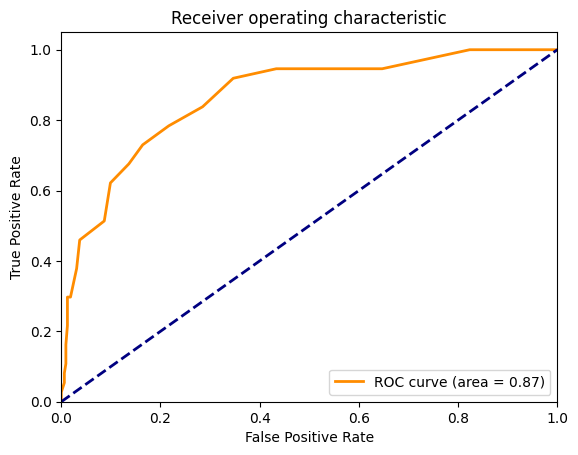

min bootstrapping aucroc:
0.7281170058947837
max bootstrapping aucroc:
0.9459877834490839
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8649565467276542(0.7959120879120879,0.9207205048326543)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8599392361111111


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


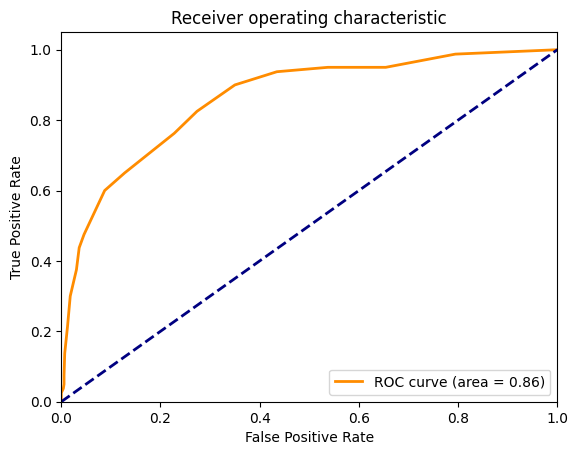

min bootstrapping aucroc:
0.7877124362405361
max bootstrapping aucroc:
0.932799442896936
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8596975256654799(0.8141675843814602,0.9020229885057471)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 434

Measure: anxiousdep
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8530006542556354


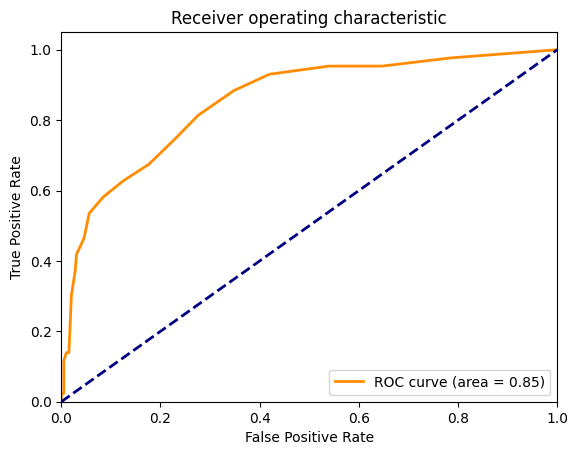

min bootstrapping aucroc:
0.7424999999999999
max bootstrapping aucroc:
0.9504146122814882
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8547668277575463(0.7930069930069931,0.9136769010824427)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 366

Measure: anxiousdep
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8674936334510802


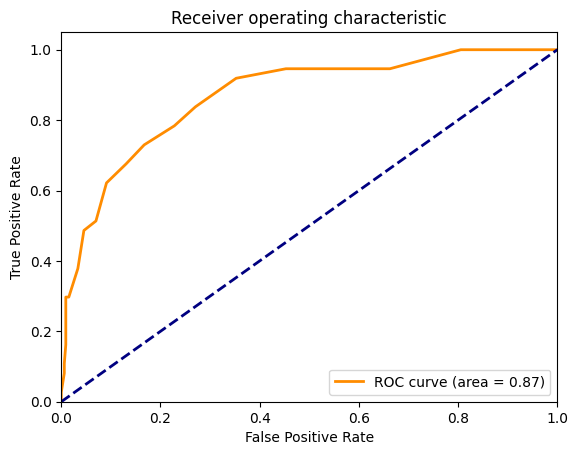

min bootstrapping aucroc:
0.7503724613816357
max bootstrapping aucroc:
0.9493098159509202
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8664373258349081(0.79826673086182,0.9259508907077516)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: anxiousdep
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.818054744861909


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


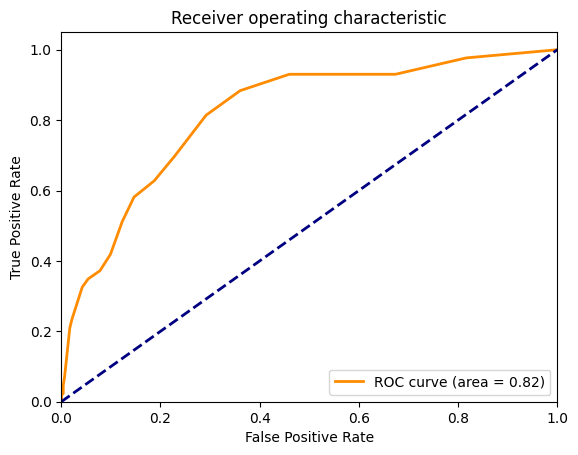

min bootstrapping aucroc:
0.7033881578947369
max bootstrapping aucroc:
0.9251226980997526
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8185008020279139(0.7507910663266874,0.875951967695087)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 442

Measure: anxiousdep
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.828249601275917


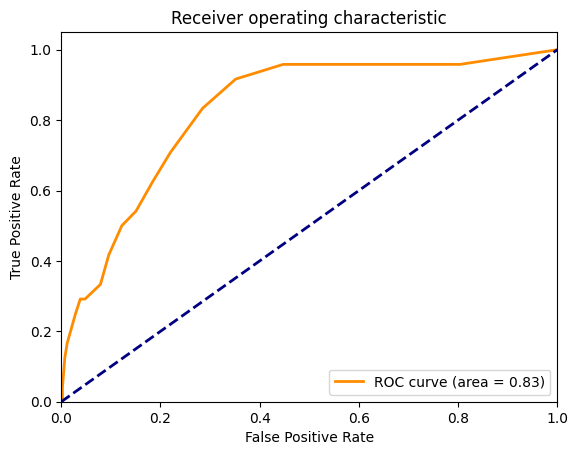

min bootstrapping aucroc:
0.6857142857142857
max bootstrapping aucroc:
0.9315139566255058
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8265763123630888(0.7368506493506493,0.8939034045922407)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 358

Measure: anxiousdep
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8049215960254619


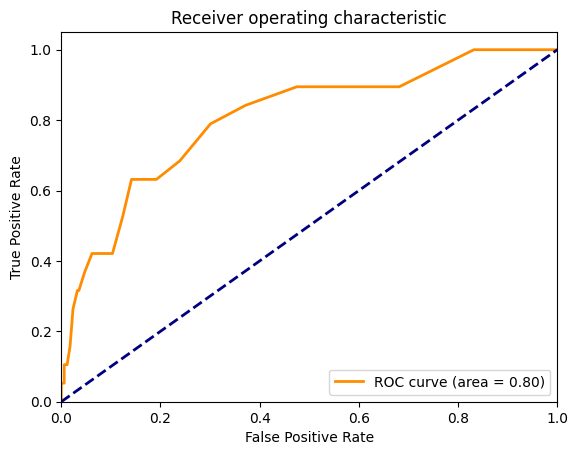

min bootstrapping aucroc:
0.6145259290659884
max bootstrapping aucroc:
0.9670977011494253
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8062453694223782(0.6847302504816956,0.899514091350826)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8479687499999999


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


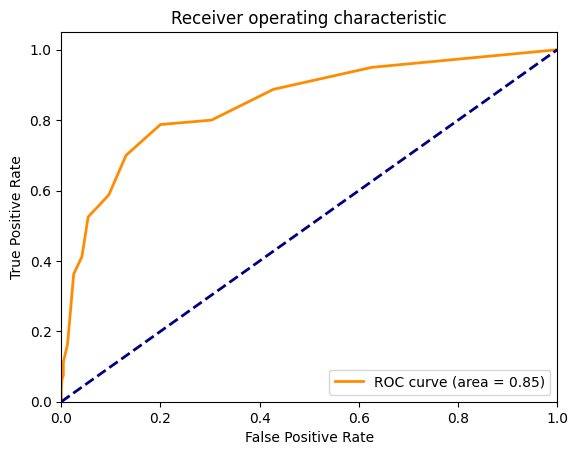

min bootstrapping aucroc:
0.7602145045965271
max bootstrapping aucroc:
0.9240331491712707
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8478899272490399(0.7973002101632808,0.8933794466403162)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 434

Measure: withdrawndep
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.875334562540891


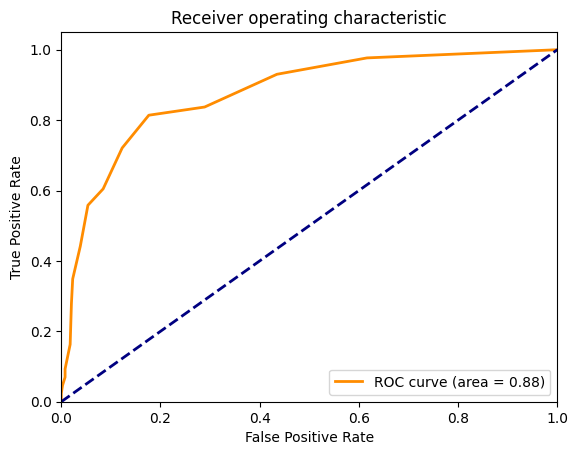

min bootstrapping aucroc:
0.756037130094919
max bootstrapping aucroc:
0.9558058375634517
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.873197276012892(0.8137722104976512,0.9257376395534289)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 366

Measure: withdrawndep
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8161915715107204


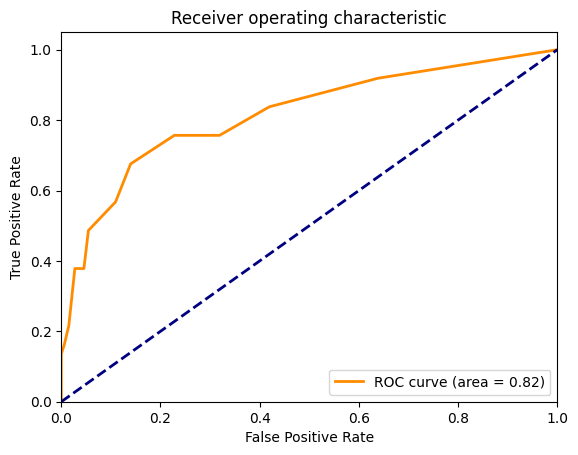

min bootstrapping aucroc:
0.6932586644125105
max bootstrapping aucroc:
0.9535869041887337
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8188701430241507(0.7381258023106547,0.8948217636022513)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8578645833333332


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


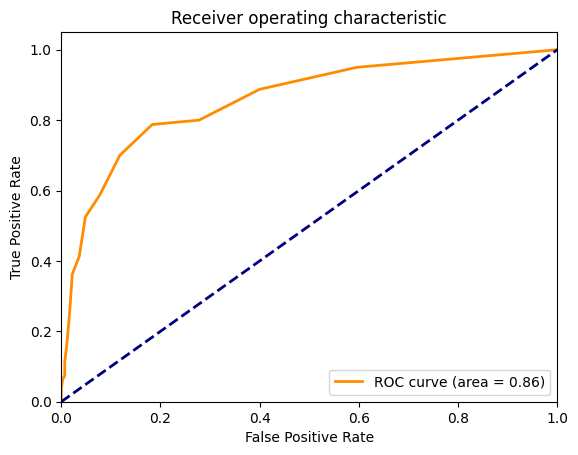

min bootstrapping aucroc:
0.7696676556821574
max bootstrapping aucroc:
0.9250249665542387
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8592205799935015(0.8100848782666965,0.9028144830160507)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 435

Measure: withdrawndep
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8859753203607024


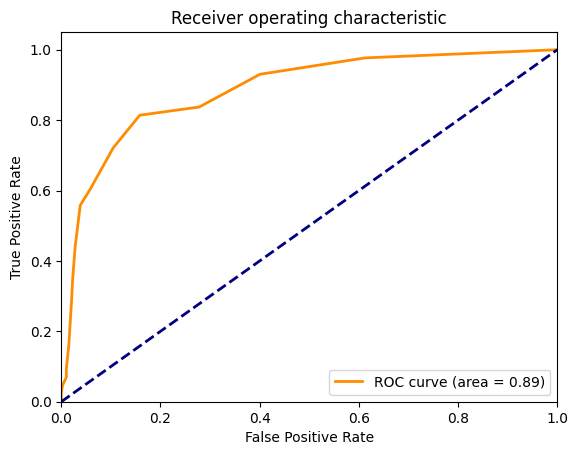

min bootstrapping aucroc:
0.7812246553122466
max bootstrapping aucroc:
0.9643827244329757
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8860660847093365(0.8289817232375978,0.9379370629370629)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 365

Measure: withdrawndep
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8264667106130521


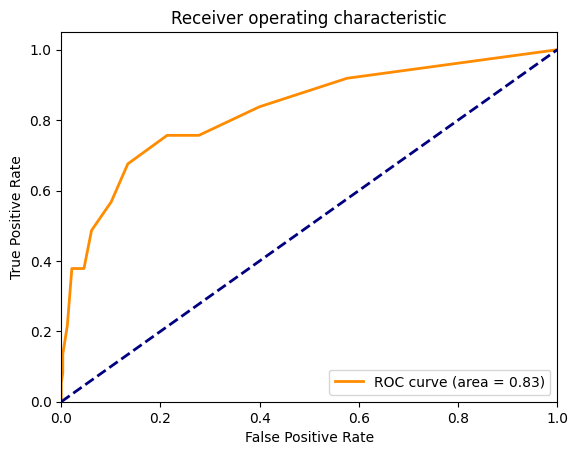

min bootstrapping aucroc:
0.6381108750241453
max bootstrapping aucroc:
0.9413097565310112
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8273352862587954(0.741625138427464,0.8997809419496167)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8672544622285029


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


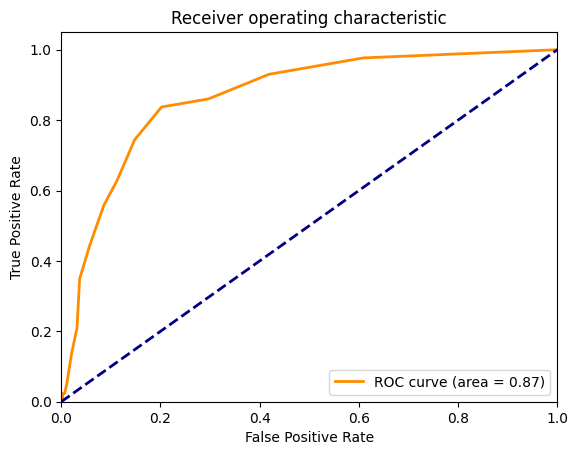

min bootstrapping aucroc:
0.7636707388016288
max bootstrapping aucroc:
0.9334278650378127
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8684241822264157(0.8147546897546898,0.9145216748610174)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 453

Measure: withdrawndep
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8817987567987569


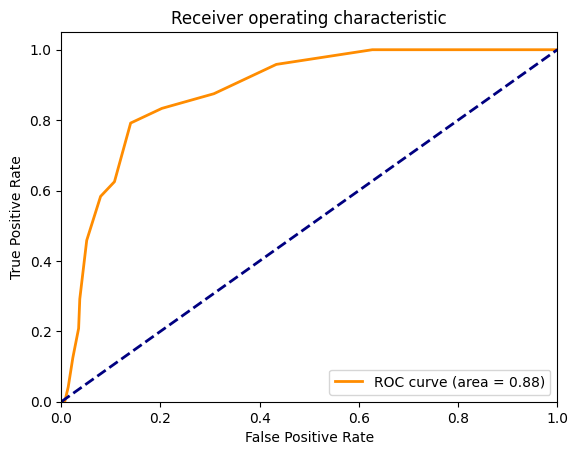

min bootstrapping aucroc:
0.7727330779054917
max bootstrapping aucroc:
0.9628504672897196
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8824831184005685(0.8176883780332056,0.9339063714063714)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 347

Measure: withdrawndep
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8497272143774068


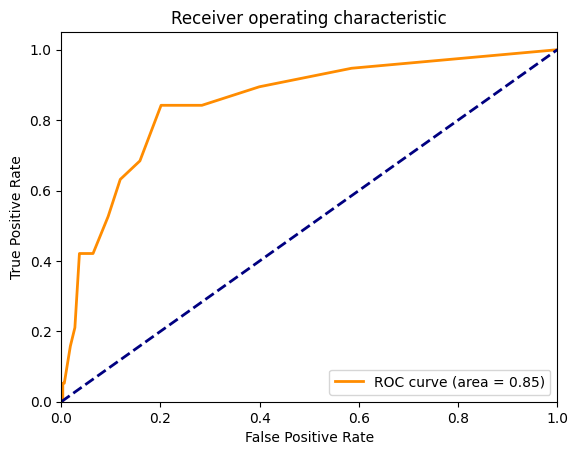

min bootstrapping aucroc:
0.6581325301204819
max bootstrapping aucroc:
0.9452736318407959
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8494295198700597(0.7411253776435045,0.9270642201834862)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8388368055555555


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


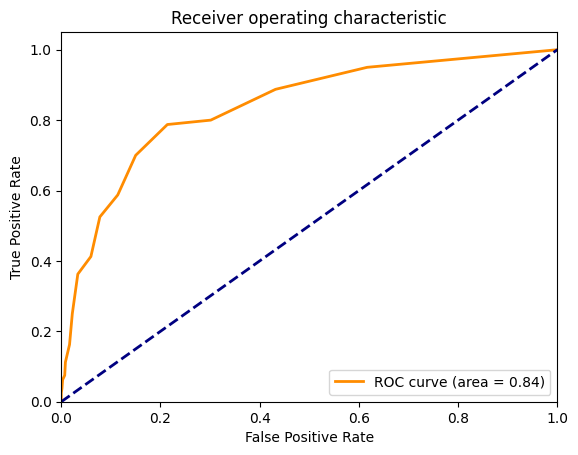

min bootstrapping aucroc:
0.7489287356321839
max bootstrapping aucroc:
0.9145892203035059
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8394456354330828(0.78859225065426,0.8864163102259237)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 407

Measure: withdrawndep
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8544914387937644


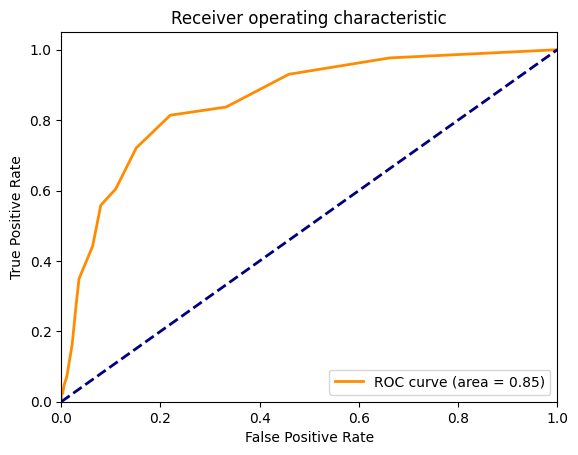

min bootstrapping aucroc:
0.7235208181154127
max bootstrapping aucroc:
0.9349916387959867
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8545364515114527(0.7933571249686953,0.9095457335788828)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 393

Measure: withdrawndep
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.820945945945946


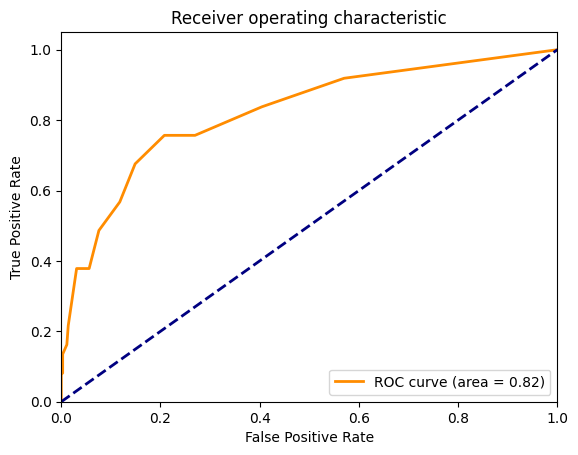

min bootstrapping aucroc:
0.6820031923383879
max bootstrapping aucroc:
0.9274410774410775
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8197625967162836(0.73493265993266,0.8915122988156696)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8465190972222221


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


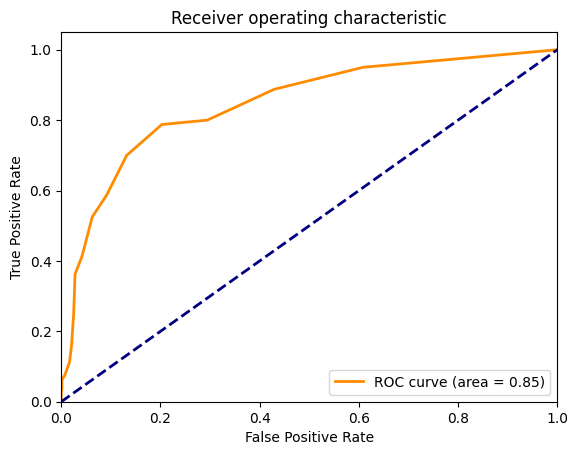

min bootstrapping aucroc:
0.7672275862068966
max bootstrapping aucroc:
0.9164977477477477
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8459045192935074(0.7942946942254421,0.8901733077633355)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 443

Measure: withdrawndep
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8712790697674418


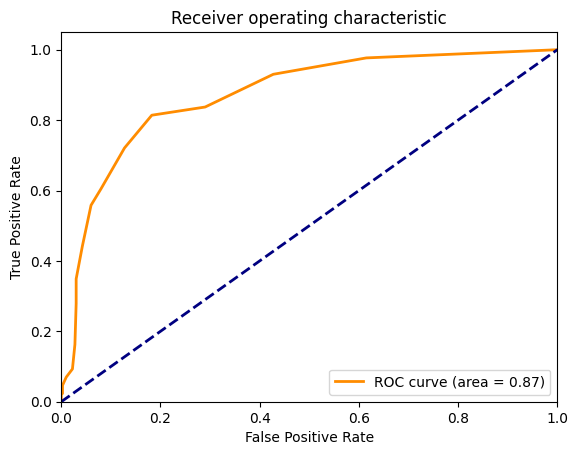

min bootstrapping aucroc:
0.7626050420168067
max bootstrapping aucroc:
0.9412531017369727
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8728874579708913(0.8149711070559611,0.9225020475020476)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 357

Measure: withdrawndep
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8179476351351351


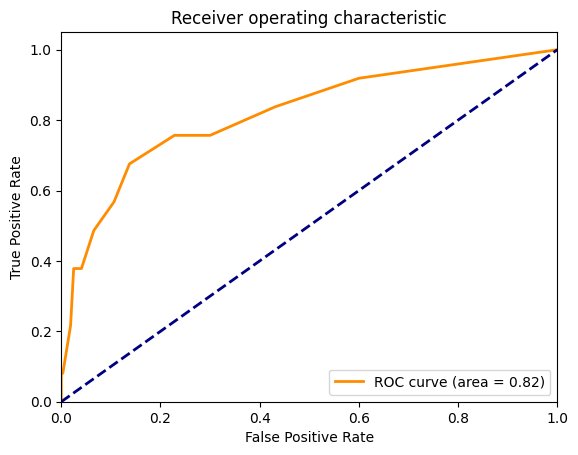

min bootstrapping aucroc:
0.6810690220360589
max bootstrapping aucroc:
0.9270192307692309
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8185251172546794(0.7291720906014059,0.8933454482519904)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8643974071457098


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


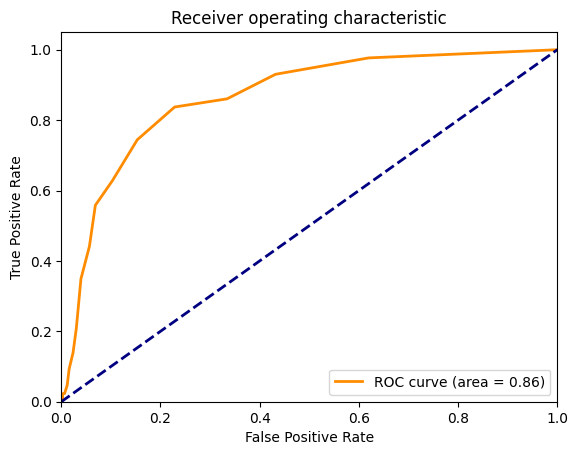

min bootstrapping aucroc:
0.7757547759449985
max bootstrapping aucroc:
0.9520208281676171
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8648397974050325(0.8136185848050256,0.9144512955288251)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 441

Measure: withdrawndep
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8826438848920863


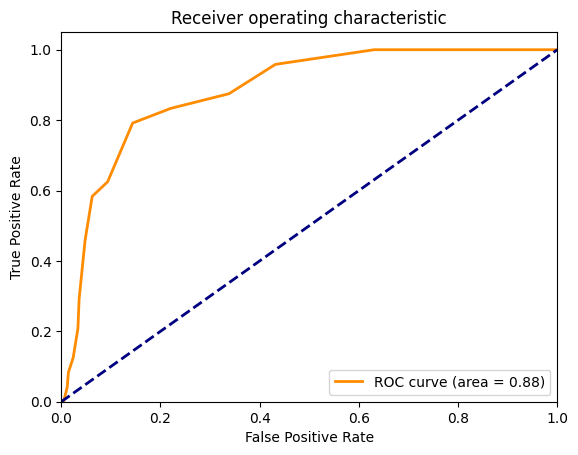

min bootstrapping aucroc:
0.7215419501133786
max bootstrapping aucroc:
0.97125
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8831871785072171(0.8133324084350722,0.9361032761987416)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 359

Measure: withdrawndep
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8428018575851394


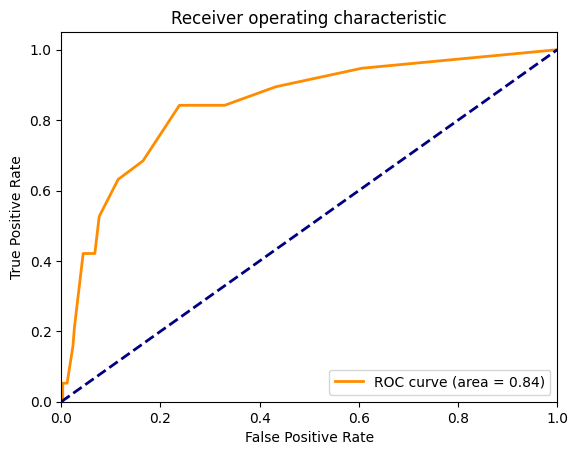

min bootstrapping aucroc:
0.6627581120943953
max bootstrapping aucroc:
0.9517758227435648
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8439150001346001(0.7310077519379845,0.9284341978866474)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8463107638888889


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


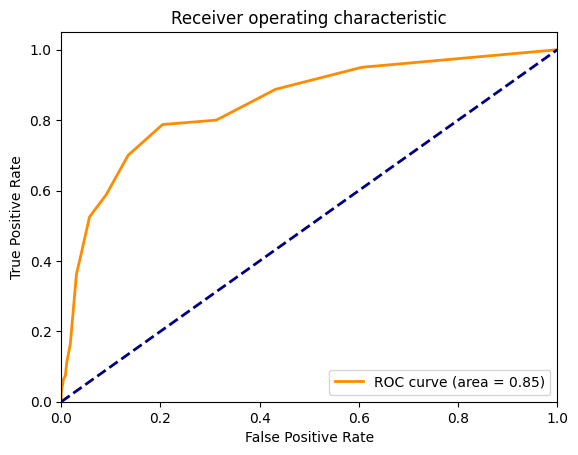

min bootstrapping aucroc:
0.752047502047502
max bootstrapping aucroc:
0.9157255486895377
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8456670608984963(0.7973540981839736,0.8892610616766101)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 446

Measure: withdrawndep
Sex: boys
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8648508280916383


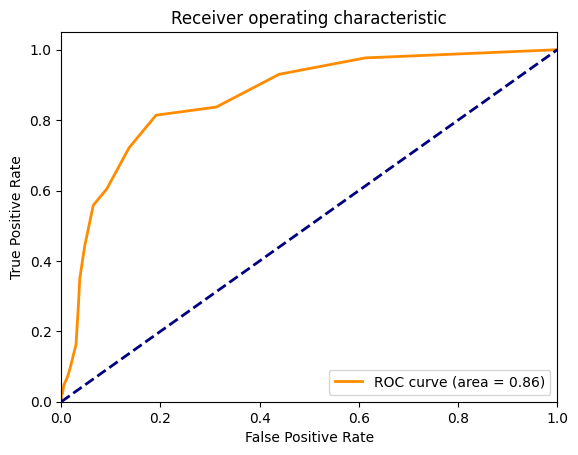

min bootstrapping aucroc:
0.7603272433780908
max bootstrapping aucroc:
0.9441994572591588
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8647737806680277(0.8061139028475712,0.914808417085427)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 354

Measure: withdrawndep
Sex: girls
Hypothesis: 1
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8251342825475318


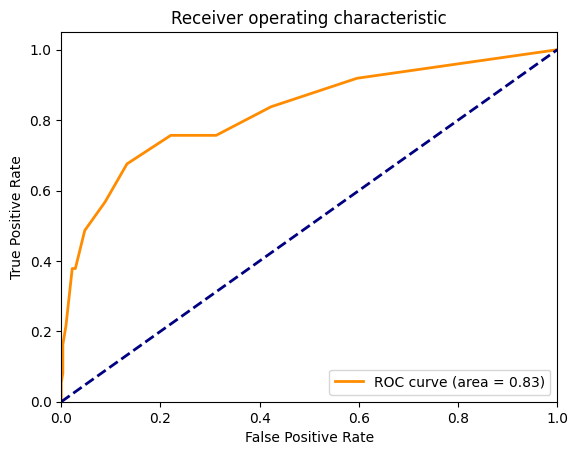

min bootstrapping aucroc:
0.6772361984626136
max bootstrapping aucroc:
0.9304153726708074
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8238769149298464(0.7411309127248501,0.9015916149068323)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8416145833333333


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


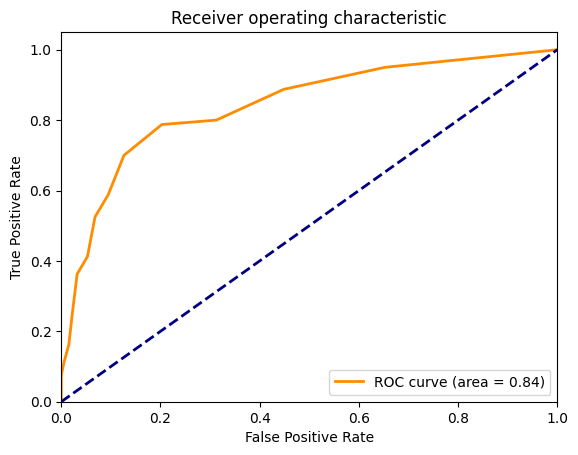

min bootstrapping aucroc:
0.7559204268833326
max bootstrapping aucroc:
0.9166952838827839
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8412062712350127(0.7892554504319211,0.8860137931034482)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 440

Measure: withdrawndep
Sex: boys
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8602015113350125


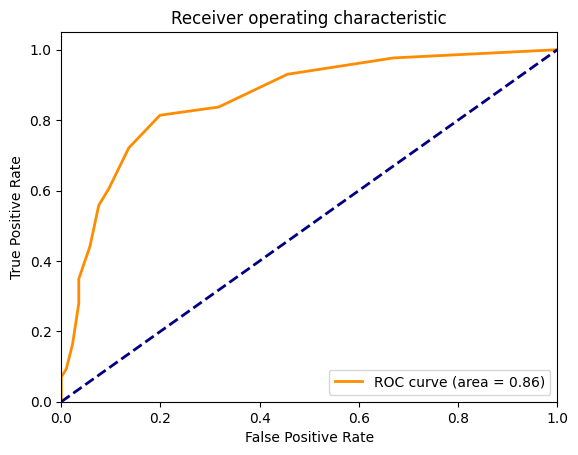

min bootstrapping aucroc:
0.6855731922398589
max bootstrapping aucroc:
0.9371075837742504
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8589799914860319(0.794912822776429,0.9154615384615383)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 360

Measure: withdrawndep
Sex: girls
Hypothesis: 2a
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8208936490670237


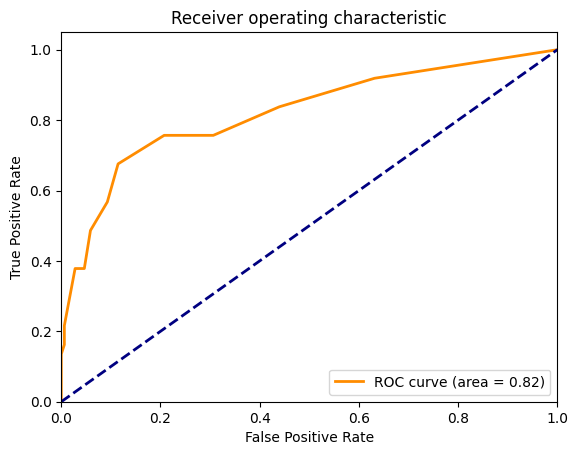

min bootstrapping aucroc:
0.6790123456790124
max bootstrapping aucroc:
0.9495907738095238
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8203120841380632(0.7291459591711904,0.8951992970684559)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:4: DtypeWarning: Columns (33,67,74,81,88,95,153,161,169,177,219,242,371,372,430,432,437,439,442,444,446,449,451,453,635,693,702,729,735,741,762,766,998,1021,1036,1040,1041,1042,1053,1067,1068,1086,1110,1111,1112,1123,1137,1138,1156,1181,1182,1183,1194,1209,1210,1228,1251,1252,1253,1264,1279,1320,1321,1322,1333,1348,1391,1392,1393,1396,1397,1404,1405,1406,1417,1432,1433,1451,1478,1479,1480,1491,1501,1505,1506,1524,1552,1553,1554,1565,1575,1597,1627,1638,1648,1670,1697,1698,1699,1710,1725,1768,1769,1770,1771,1774,1775,1776,1781,1783,1786,1787,1788,1793,1795,1798,1799,1800,1805,1807,1810,1811,1812,1815,1816,1817,1820,1821,1822,1827,1828,1829,1844,1845) have mixed types. Specify dtype option on import or set low_memory=False.
  bhrcfile = pd.read_csv(path_to_mydata)
/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of


Depressed 9 to 13 - clinician
depression_clinician_9to13
False    2003
True       80
Name: count, dtype: int64

Healthy 9 to 13 - clinician
healthy_clinician_9to13
True     2003
False      80
Name: count, dtype: int64

depYES_anxietyadhdNO_clinician - clinician
depYES_anxietyadhdNO_clinician_9to13
False    2040
True       43
Name: count, dtype: int64

depNO_anxietyadhdYES_clinician - clinician
depNO_anxietyadhdYES_clinician_9to13
False    1723
True      360
Name: count, dtype: int64

all 9 to 13
all_9to13
True    2083
Name: count, dtype: int64

EQUALS??
False

Hypothesis = 1
All positives in sample = 80
All negatives in sample = 2003

Measure: withdrawndep
Sex: both
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8651039906608091


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_30598/3727760565.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mybhrcfile['gs_depression'] = mybhrcfile['depression_clinician_9to13'].astype(int)


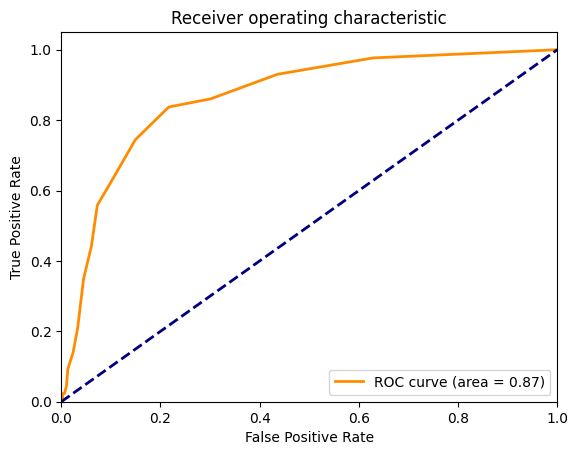

min bootstrapping aucroc:
0.7663486842105263
max bootstrapping aucroc:
0.9427541359210216
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8649465621641942(0.8086848330312433,0.9117231421461707)

...END AUCROC
Length of dataset - sex n = boys, sample size n = 405

Measure: withdrawndep
Sex: boys
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8913495188101488


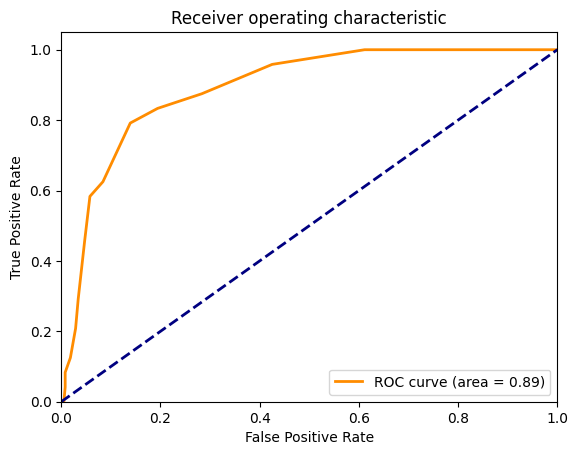

min bootstrapping aucroc:
0.7825150732127476
max bootstrapping aucroc:
0.963465403387884
p_onesided = 1
p_twosided = 0
boots_mean_AUCROC =
0.8918361609713982(0.8374222222222223,0.9417070952092178)

...END AUCROC
Length of dataset - sex n = girls, sample size n = 395

Measure: withdrawndep
Sex: girls
Hypothesis: 2b
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8356662933930571


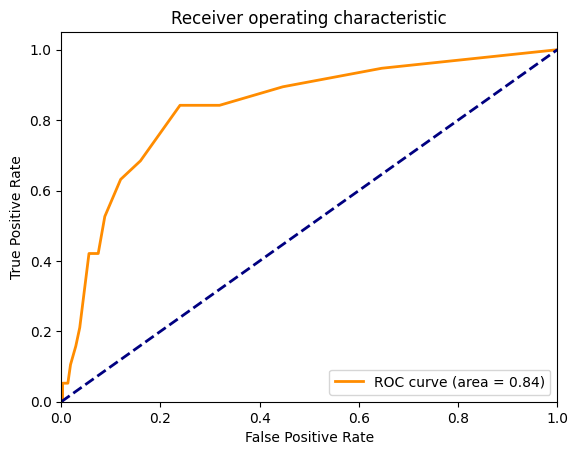

min bootstrapping aucroc:
0.4335038363171355
max bootstrapping aucroc:
0.9617414248021108
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8354799326162652(0.7264150943396227,0.9186000000000001)

...END AUCROC

FINISH ALL


In [86]:
for measure in ['cbclaff', 'anxiousdep', 'withdrawndep']:
    for sex in ['both', 'boys', 'girls']:
        for hypothesis in ['1', '2a', '2b']:
            bhrc_both = load_bhrc(path_to_mydata=path_to_bhrcfile, hypothesis = '1', do_print = False)
            for sex in ['both', 'boys', 'girls']:
                if sex == 'both':
                    mydata = bhrc_both
                else:
                    mydata = split_sex(bhrc_both, path_to_demofile, sex=sex)        
                print('\nMeasure: %s' % measure)        
                print('Sex: %s' % sex)        
                print('Hypothesis: %s' % hypothesis) 
                if hypothesis in ['1', '2a']:
                    Target_auc = 0.8 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                elif hypothesis == '2b':
                    Target_auc = 0.7 # [TODO] NEED TO DOUBLE CHECK THIS WITH SAMPLE SIZE ESTIMATION ETC
                fig_file_name = 'BHRC_'+measure+'_'+hypothesis+'_'+sex
                y_true,y_measure = run_aucroc_and_plot(mydata, 
                                                                    path_to_save_plots='../plotting/plot_data/', 
                                                                    name_to_save=fig_file_name, 
                                                                    mymeasure = measure, 
                                                                    hypothesis = hypothesis,
                                                                    nboots=100, 
                                                                    target_auc=Target_auc)
            
print('\nFINISH ALL')